# Pathway Activity in Human PBMC Single Cells

Single-cell RNA-seq provides unprecedented insights into variations in cell types between conditions, tissue types, species and individuals. Differential gene expression analysis of the single-cell data is almost always followed by *gene set enrichment analysis*, where the aim is to identify gene programs, such as biological processes, gene ontologies or regulatory pathways that are over-represented in an experimental condition compared to control or other conditions, on the basis of differentially expressed (DE) genes.

### Pathway activity tests

Gene set tests test whether a pathway is enriched, in other words over-represented, in one condition compared to others, say, in healthy donors compared to severe COVID-19 patients. An alternative approach is to simply score the activity of a pathway or gene signature, in absolute sense, in individual cells, rather than testing for a differential activity between conditions. Some of the widely used tools for inference of gene set activity in general (including pathway activity) in individual cells include *VISION* {cite}`detomaso2019functional`, *AUCell* <cite>`aibar2017scenic`</cite>, pathway overdispersion analysis using *Pagoda2* <cite>`fan2016characterizing, lake2018integrative`</cite> and simple combined z-score <cite>`lee2008inferring`</cite>. 

*DoRothEA* <cite>`garcia2019benchmark`</cite> and *PROGENy* <cite>`schubert2018perturbation`</cite> are among functional analysis tools developed to infer transcription factor (TF) - target activities originally in Bulk RNA data. Holland et al. <cite>`holland2020robustness`</cite> found that Bulk RNA-seq methods *DoRothEA* and *PROGENy* have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single cell data. Holland et al. also concluded that pathway and TF activity inference is more sensitive to the choice of gene sets rather than the statistical methods. This observation though can be specific to functional enrichment analyses and be explained by the fact that TF-target relations are context-specific; that is TF-target associations in one cell type may actually differ from another cell type or tissue.  

In contrast to Holand et al., Zhang et al. <cite>`zhang2020benchmarking`</cite> found that single-cell-based tools, specifically Pagoda2, outperform bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that pathway and gene set activity inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

We first download the 68K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes.

In [20]:
%reload_ext autoreload
%autoreload 2
from __future__ import annotations
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so
from tqdm.notebook import tqdm
import session_info
import os
import warnings
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import scanpy.external as sce
from scipy.optimize import linear_sum_assignment
from metrics import *
import scprep
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import magic
from activity import *


#!pip install ipywidgets --upgrade
os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.logging.print_versions()
#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
activity            NA
asttokens           NA
attr                23.2.0
certifi             2024.07.04
cffi                1.17.0
charset_normalizer  3.3.2
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
decoupler           1.7.0
deprecated          1.2.14
dill                0.3.8
docrep              0.3.2
exceptiongroup      1.2.1
executing           2.0.1
future              1.0.0
graphtools          1.5.3
h5py                3.11.0
idna                3.7
igraph              0.11.6
importlib_resources NA
inflect             NA
ipykernel           6.29.4
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
louvain             0.8.2
magic               3.0.0
matplotlib   

The original dataset is from a single donor, from 10xgenomix. Fresh 68k PBMCs (Donor A).

- ~68,000 cells detected
- Sequenced on Illumina NextSeq 500 High Output with ~20,000 reads per cell
- 98bp read1 (transcript), 8bp I5 sample barcode, 14bp I7 GemCode barcode and 5bp read2 (UMI)
- Analysis run with --cells=24000

In [21]:
adata = sc.datasets.pbmc68k_reduced()
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
adata.obs['labels'] = adata.obs.bulk_labels.map({'CD14+ Monocyte':0, 'Dendritic':1, 'CD56+ NK':2, 'CD4+/CD25 T Reg':3, 'CD19+ B':4, 'CD8+ Cytotoxic T':5, 'CD4+/CD45RO+ Memory':6, 'CD8+/CD45RA+ Naive Cytotoxic':7, 'CD4+/CD45RA+/CD25- Naive T':8, 'CD34+':9})

In [23]:
sc.pp.filter_cells(adata, min_genes=2)
#sc.pl.highest_expr_genes(adata, n_top=20)

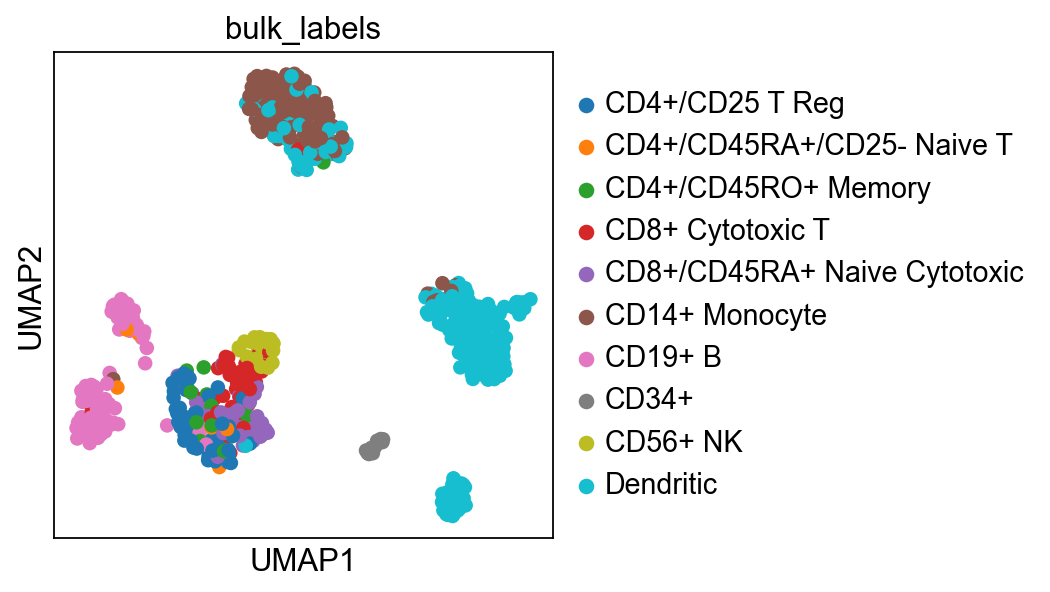

In [5]:
sc.pl.umap(adata, color=["bulk_labels"])

## GSEA

#### Retrieving gene sets
Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [5]:
#Downloading reactome pathways.
from pathlib import Path

if not Path("./data/c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O './data/c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("./data/c2.cp.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

In [6]:
#Prepare the result matrix for GSEA scores.
num_cells = adata.shape[0]
num_gene_sets = len(reactome['geneset'].unique())
gsea_results_matrix = np.zeros((num_cells, num_gene_sets))

#Loop through each cell to run GSEA.
for cell_index in tqdm(range(num_cells)):
    #Get normalized expression values for the specific cell.
    cell_expr = adata.X[cell_index]
    
    #Create a DataFrame to hold DE scores.
    de_scores = pd.DataFrame(cell_expr, index=adata.var_names, columns=['scores'])
    
    #Run GSEA using decoupler.
    _, norm, _ = decoupler.run_gsea(
        de_scores.T,
        reactome,
        source="geneset",
        target="genesymbol"
    )
    
    #Store the normalized enrichment scores (NES) in the result matrix.
    gsea_results_matrix[cell_index, :] = norm.iloc[:, 0].values

#Save the result matrix for later use.
np.save('./data/gsea_results_matrix.npy', gsea_results_matrix)

100%|██████████| 700/700 [20:21<00:00,  1.75s/it]


### Cluster With KMeans

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


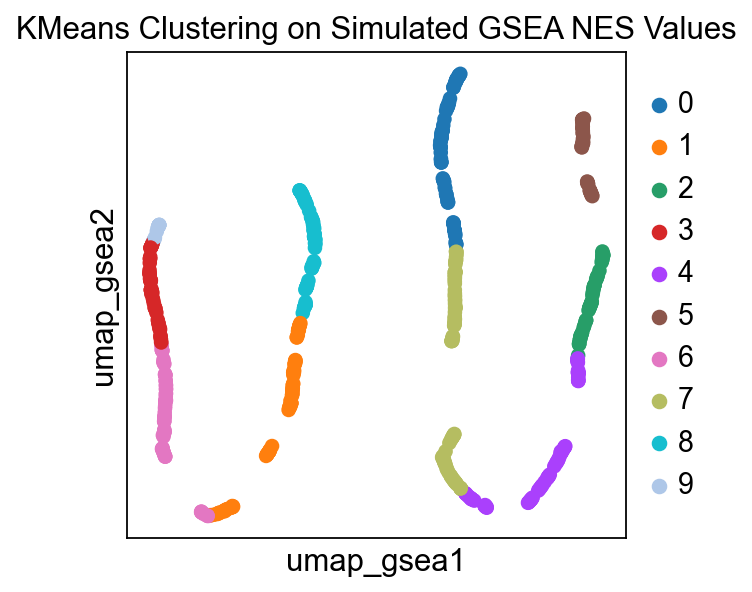

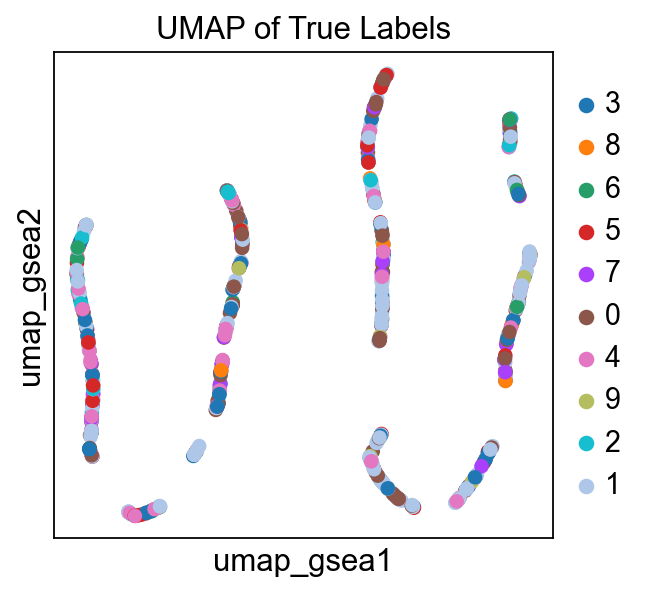

In [9]:
#Load the simulated GSEA results matrix.
gsea_results_matrix = np.load('./data/gsea_results_matrix.npy')

#Convert the result matrix to an AnnData object for visualization.
#adata_gsea = sc.AnnData(X=gsea_results_matrix)
#adata_gsea.var_names = [f'GeneSet_{i}' for i in range(gsea_results_matrix.shape[1])]
#adata_gsea.obs_names = [f'Cell_{i}' for i in range(gsea_results_matrix.shape[0])]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(gsea_results_matrix)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15, random_state=0)
umap_coords = umap_model.fit_transform(gsea_results_matrix)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_gsea'] = umap_coords
adata.obs['kmeans_gsea'] = pd.Categorical(kmeans.labels_)

#Plot the UMAP with KMeans clustering results using Scanpy.
#sc.pl.umap(adata, color=['kmeans1'], title='KMeans Clustering on Simulated GSEA NES Values', obsm_key='umap_gsea')
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels", obsm_key='umap_gsea')
sc.pl.embedding(adata, basis='umap_gsea', color=['kmeans_gsea'], title='KMeans Clustering on Simulated GSEA NES Values')
sc.pl.embedding(adata, basis='umap_gsea', color=["labels"], title="UMAP of True Labels")

### Cluster Results

 - Silhouette Score: This score measures how similar a point is to its own cluster compared to other clusters. The silhouette_score function from sklearn.metrics is used. The Silhouette score ranges from -1 to 1, where a higher value indicates better-defined clusters. A score close to 0 suggests that clusters are overlapping or poorly defined. A negative value, as in this case, typically indicates that data points might have been assigned to the wrong clusters. Given that your score is slightly negative, it suggests potential issues with cluster separability or consistency.

 - Calinski-Harabasz Index: This index evaluates the ratio of the sum of between-cluster dispersion and of within-cluster dispersion. The calinski_harabasz_score function from sklearn.metrics is used. The Calinski-Harabasz index, also known as the Variance Ratio Criterion, is used to assess cluster separation. Higher values indicate better-defined clusters.
 
 - Dunn Index: This index is calculated by finding the minimum inter-cluster distance and dividing it by the maximum intra-cluster distance. The custom function dunn_index is used to compute this.
 The Dunn index evaluates cluster compactness and separation. Higher values are better, indicating well-separated and compact clusters.

In [60]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['X_umap']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: -0.14324577895131899
Calinski-Harabasz Index: 1.8725756454607307
Special accuracy: 0.1742857142857143
completeness score: 0.033711580321108464
homogeneity_score: 0.039510598801457124
adjusted_mutual_info_score: 0.006331171264694209
CPU times: total: 15.6 ms
Wall time: 35.3 ms


'\nSilhouette Score: 0.06242213025689125\nCalinski-Harabasz Index: 4.044869615938594\nDunn Index: 0.0002734548919755451\nSpecial accuracy: 0.5135792460478313\n'

## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [24]:
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [25]:
decoupler.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running mlm on mat with 700 samples and 765 targets for 14 sources.


### Cluster With KMeans

Pathway activity matrix shape: (700, 14)


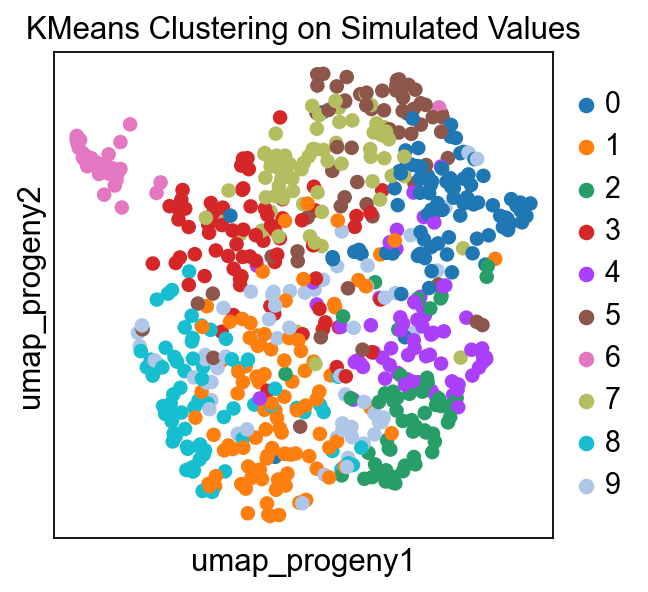

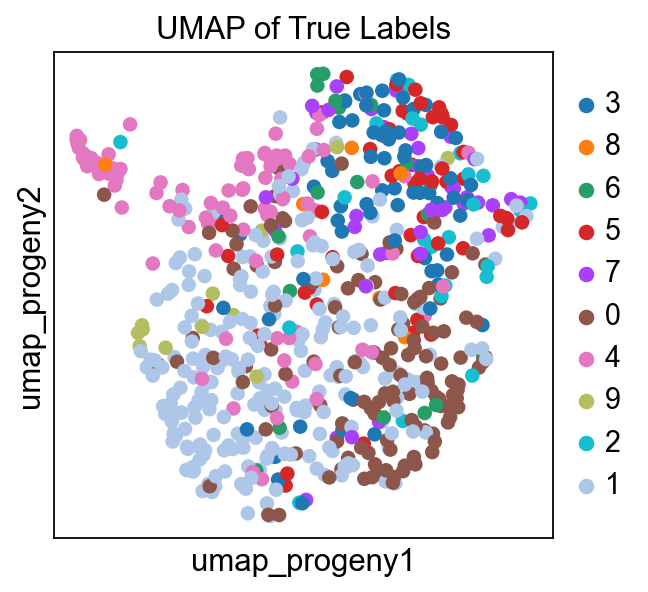

In [26]:
acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_progeny'] = umap_coords
adata.obs['kmeans_progeny'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
#sc.pl.umap(adata, color=["kmeans2"], title="KMeans Clustering on PROGENy Model Values.")
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels")
sc.pl.embedding(adata, basis='umap_progeny', color=['kmeans_progeny'], title='KMeans Clustering on Simulated Values')
sc.pl.embedding(adata, basis='umap_progeny', color=["labels"], title="UMAP of True Labels")

### Cluster Results

In [27]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.07565734535455704
Calinski-Harabasz Index: 42.45235984033675
Special accuracy: 0.27714285714285714
completeness score: 0.20676705373417534
homogeneity_score: 0.24605185278731567
adjusted_mutual_info_score: 0.20062782857262176


## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [13]:
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
    verbose=True
)

Running aucell on mat with 700 samples and 765 targets for 266 sources.


100%|██████████| 700/700 [00:01<00:00, 388.99it/s]


### Cluster With KMeans

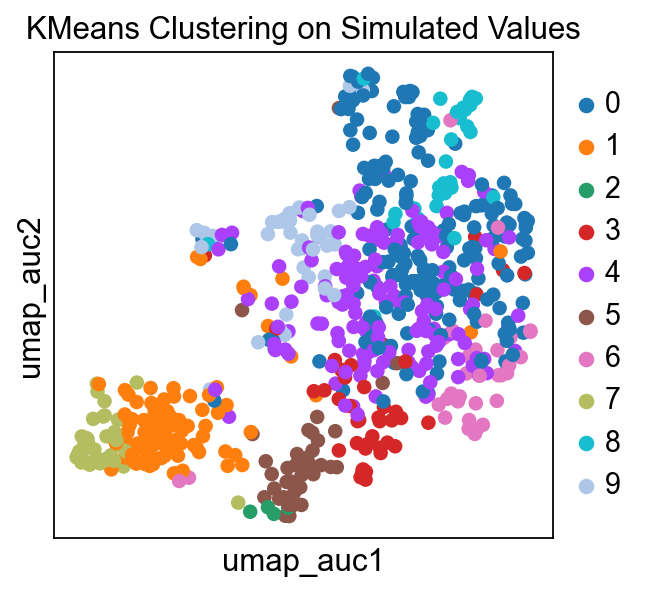

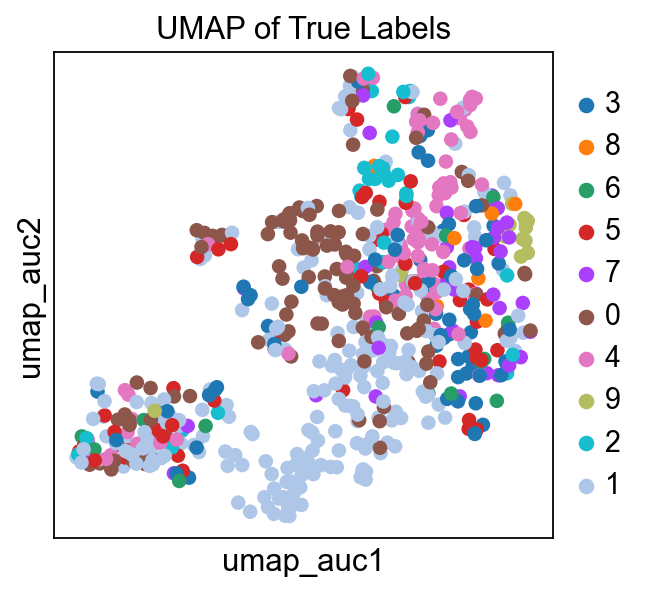

In [14]:
#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = adata.obsm["aucell_estimate"]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15)
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_auc'] = umap_coords
adata.obs['kmeans_auc'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
#sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on AUCELL Values.")
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels")
sc.pl.embedding(adata, basis='umap_auc', color=['kmeans_auc'], title='KMeans Clustering on Simulated Values')
sc.pl.embedding(adata, basis='umap_auc', color=["labels"], title="UMAP of True Labels")

### Cluster Results

In [11]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['aucell_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.02171320840716362
Calinski-Harabasz Index: 24.73854855496907
Special accuracy: 0.25
completeness score: 0.1942410750812647
homogeneity_score: 0.20188840038690453
adjusted_mutual_info_score: 0.1721049341248813


'\nSilhouette Score: 0.13764698803424835\nCalinski-Harabasz Index: 3215.894450359765\nDunn Index: 0.2627693665418968\n\nSilhouette Score: 0.13764698803424835\nCalinski-Harabasz Index: 3215.894450359765\nSpecial accuracy: 0.5055728934462773\ncompleteness score: 0.00014320899703728832\nhomogeneity_score: 0.0001241064534269903\nadjusted_mutual_info_score: 0.00010165028332201413\n'

## PathSingle

### Run Magic

In [82]:
# We prefer using rawcounts for magic imputation.
#adata.X = adata.layers['counts'].copy()
activity_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
#activity_df = scprep.normalize.library_size_normalize(activity_df)
#activity_df = scprep.transform.sqrt(activity_df)

magic_op = magic.MAGIC()
activity_df = magic_op.fit_transform(activity_df)
activity_df.to_csv('./data/activity_df.csv', index=True)

Calculating MAGIC...
  Running MAGIC on 700 cells and 765 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.23 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.27 seconds.


### Run PathSingle

In [83]:
activity = sc.read('./data/activity_df.csv', delimiter=',', cache=False)
calc_activity(activity)

AnnData object with n_obs × n_vars = 700 × 765


100%|██████████| 140/140 [01:49<00:00,  1.28it/s]


### Cluster With KMeans

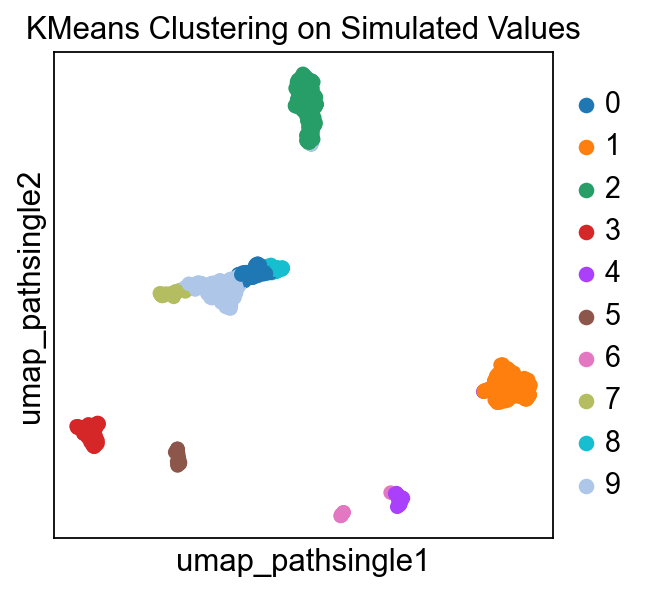

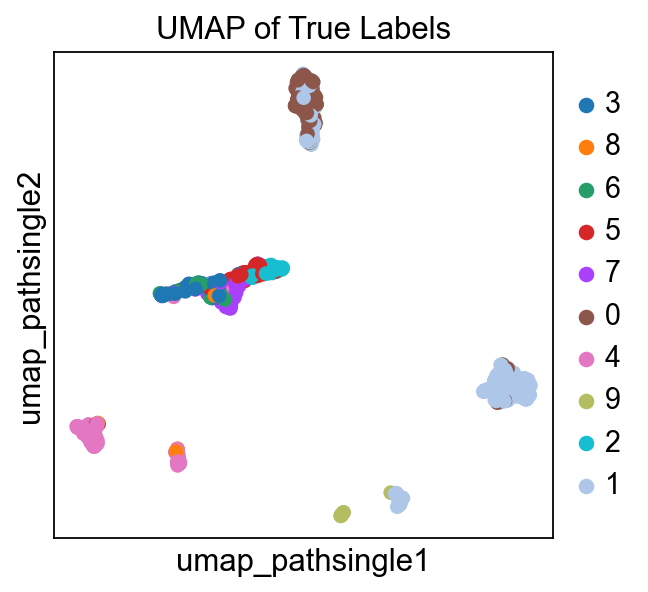

In [17]:
from sklearn.decomposition import PCA


output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

#Scale the data.
scaler = StandardScaler()
output_activity = scaler.fit_transform(output_activity)
PCA = PCA(n_components=50, svd_solver='arpack')
output_activty = PCA.fit_transform(output_activity)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=10, random_state=0).fit(output_activity)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(output_activity)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['umap_pathsingle'] = umap_coords
adata.obs['kmeans_pathsingle'] = pd.Categorical(kmeans.labels_)
#cell_state = adata.obs['labels']
#cdata.obs['state'] = cell_state[emt_magic.index].values

#Plotting UMAP with KMeans clustering results using scanpy.
#sc.pl.umap(adata, color=["kmeans4"], title="KMeans Clustering on PathSingle Model Values.")
#sc.pl.umap(adata, color=["labels"], title="UMAP of True Labels")
sc.pl.embedding(adata, basis='umap_pathsingle', color=['kmeans_pathsingle'], title='KMeans Clustering on Simulated Values')
sc.pl.embedding(adata, basis='umap_pathsingle', color=["labels"], title="UMAP of True Labels")

### Cluster Results

In [86]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = output_activity

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.labels

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.5455749862953692
Calinski-Harabasz Index: 791.3431390362056
Special accuracy: 0.6442857142857142
completeness score: 0.6291440318652685
homogeneity_score: 0.6560475130356326
adjusted_mutual_info_score: 0.6305331425838091
CPU times: total: 922 ms
Wall time: 613 ms


'\nSilhouette Score: 0.3299906551837921\nCalinski-Harabasz Index: 7361.734349622491\nDunn Index: 0.02108178870064121\n0.5016009402991124\n\nSilhouette Score: 0.43027883768081665\nCalinski-Harabasz Index: 15094.000534262332\nDunn Index: 0.030910595645710495\n0.5042759291533255\n\nSilhouette Score: 0.5255643129348755\nCalinski-Harabasz Index: 3859.402240364315\nDunn Index: 0.02282853897549874\nSpecial accuracy: 0.5020267531414674\n\nSilhouette Score: 0.3935227394104004\nCalinski-Harabasz Index: 922.9809794940934\nDunn Index: 0.2553697007099271\nSpecial accuracy: 0.522740696987596\n\nSilhouette Score: 0.563823646025838\nCalinski-Harabasz Index: 2785.9250868677827\nSpecial accuracy: 0.5022294284556141\ncompleteness score: 7.513792057228478e-06\nhomogeneity_score: 5.817606581201096e-06\nadjusted_mutual_info_score: -0.00032350134218196236\n\nSilhouette Score: 0.3494242484061349\nCalinski-Harabasz Index: 907.4838150810418\nSpecial accuracy: 0.5111471422780706\ncompleteness score: 0.0003060058

In [19]:
adata.write("./data/adata_pbmc.h5ad")

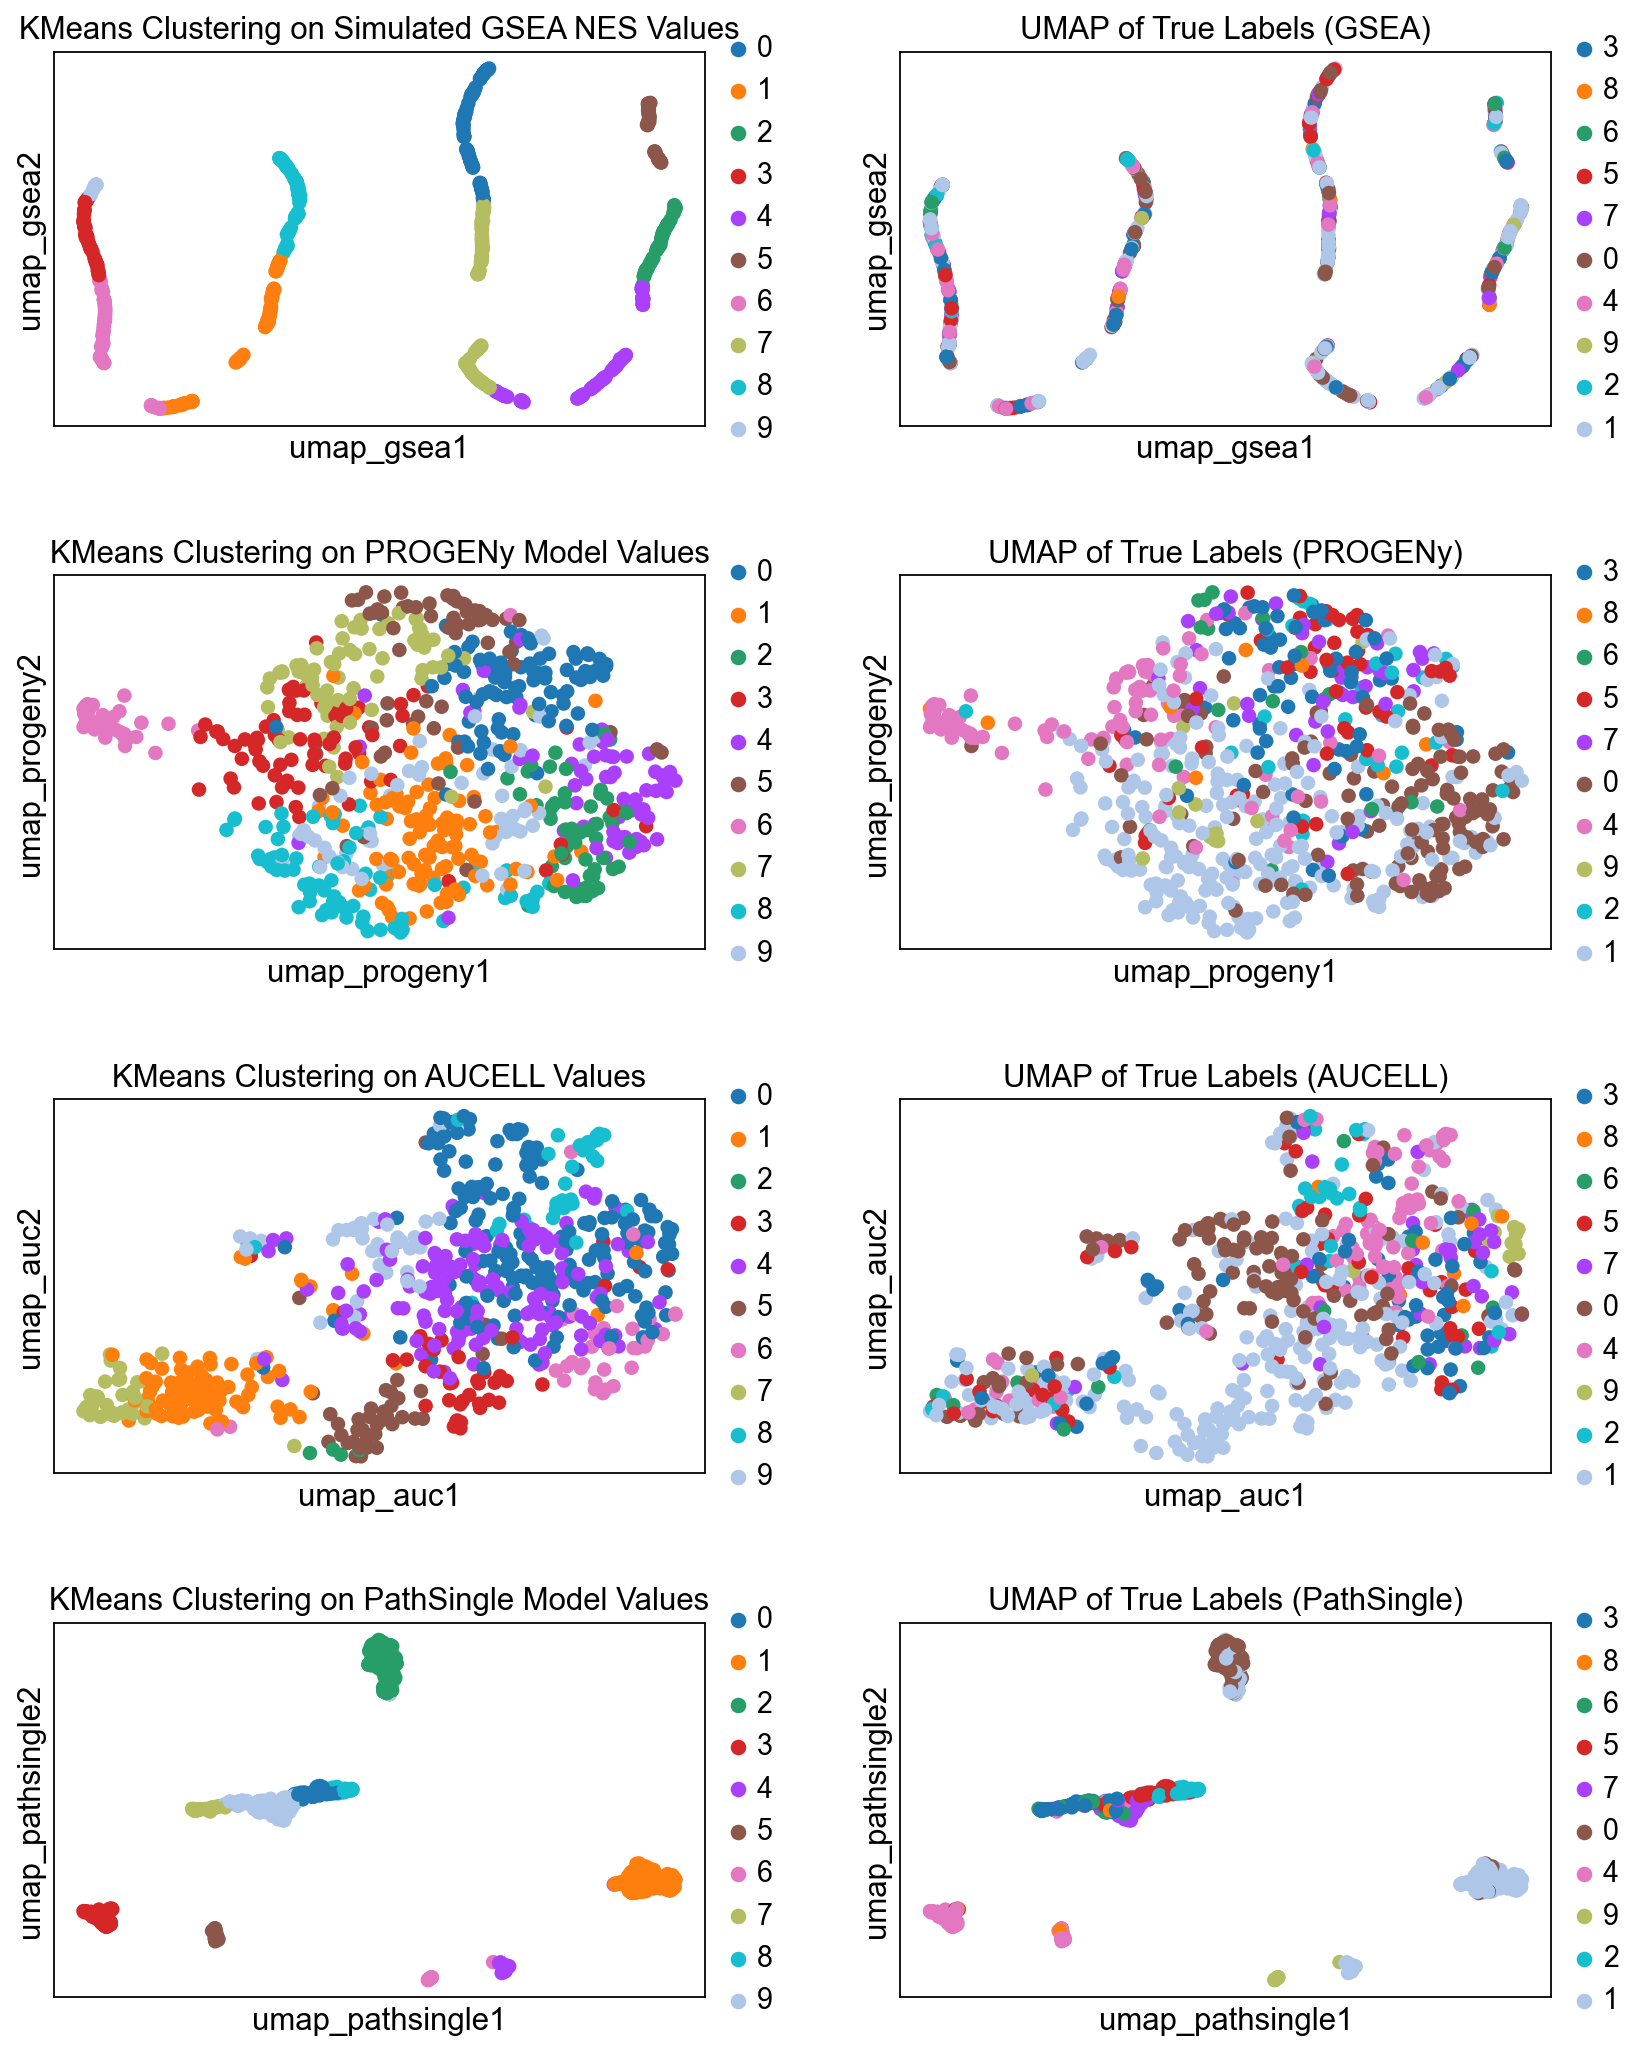

In [18]:
#adata = sc.read_h5ad("./data/adata_pbmc.h5ad")
# Define a figure with a 4x2 grid (4 rows, 2 columns).
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Adjust the spacing between plots.
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Define the plotting function for each subplot using sc.pl.embedding.
def plot_umap(ax, adata, umap_key, color, title):
    sc.pl.embedding(adata, basis=umap_key, color=color, title=title, ax=ax, show=False)
    ax.set_frame_on(True)  # Add a frame to each subplot.

# Plot each UMAP with its KMeans clustering and true labels side by side.

# Plot UMAP for GSEA.
plot_umap(axs[0, 0], adata, 'umap_gsea', color='kmeans_gsea', title='KMeans Clustering on Simulated GSEA NES Values')
plot_umap(axs[0, 1], adata, 'umap_gsea', color="labels", title="UMAP of True Labels (GSEA)")

# Plot UMAP for PROGENy.
plot_umap(axs[1, 0], adata, 'umap_progeny', color="kmeans_progeny", title="KMeans Clustering on PROGENy Model Values")
plot_umap(axs[1, 1], adata, 'umap_progeny', color="labels", title="UMAP of True Labels (PROGENy)")

# Plot UMAP for AUCELL.
plot_umap(axs[2, 0], adata, 'umap_auc', color="kmeans_auc", title="KMeans Clustering on AUCELL Values")
plot_umap(axs[2, 1], adata, 'umap_auc', color="labels", title="UMAP of True Labels (AUCELL)")

# Plot UMAP for PathSingle.
plot_umap(axs[3, 0], adata, 'umap_pathsingle', color="kmeans_pathsingle", title="KMeans Clustering on PathSingle Model Values")
plot_umap(axs[3, 1], adata, 'umap_pathsingle', color="labels", title="UMAP of True Labels (PathSingle)")

# Save the figure to a file.
plt.savefig("umap_clustering_layout.png", dpi=300, bbox_inches='tight')

# Show the figure.
plt.show()

## Session info

In [12]:
session_info.show()

### References

https://www.sc-best-practices.org/conditions/gsea_pathway.html

https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

https://en.wikipedia.org/wiki/Dunn_index

https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.

https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_04_clustering.html

https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc68k_reduced.html#norm

https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

https://www.10xgenomics.com/datasets/fresh-68-k-pbm-cs-donor-a-1-standard-1-1-0